# Bayesian Regression With PyStan
Regression models are pretty common models, but not often looked at from teh Bayesian point of view. We know that we are modeling some output $y_i$ as a linear transformation of some input $x_i$ with some error $\epsilon_i$.

$$
  y_i = \beta^T x_i + \beta_0 + \epsilon_i.
$$

where $\epsilon_i \sim \mathcal N(0,\sigma^2)$, which in turn implies that $y_i \sim \mathcal N(\beta^T x_i + \beta_0,\sigma^2)$.

Let's simulate some data that satifies these assumptions.

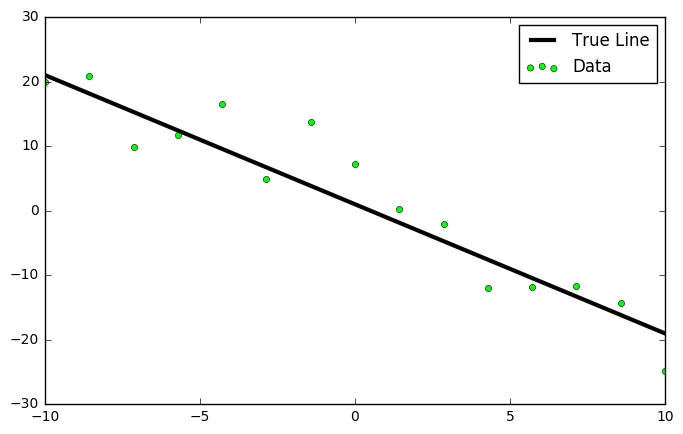

In [2]:
import pystan 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

nTrainingExamples = 15

# Set slope, beta, and intercept, beta_0.
beta = -2
beta_0 = 1

# Add noise
sigma = 5
epsilon = np.random.normal(0, sigma, nTrainingExamples)

x_low, x_hi = [-10, 10]
X = np.linspace(x_low, x_hi, nTrainingExamples)
Y = beta*X + beta_0 + epsilon

def plotData(x, y, alpha, beta, x_range, estimates = None):
    p = plt.figure("Data With Correct Line",
               figsize=[8,5])
    plt.xlim(x_range[0], x_range[1])

    # Plot the data
    plt.scatter(x,y, lw=0.4, 
                edgecolors="black",
                color="lime", 
                label="Data")
    
    # plot estimaet line if given
    if estimates is not None:
        beta_hat = estimates[0]
        beta0_hat = estimates[1]
        predict = lambda x: beta_hat*x + beta0_hat
        plt.plot([x_range[0],x_range[1]],
            [predict(x_range[0]),predict(x_range[1])], 
            color="royalblue",
            lw=4, 
            label="Prediction")
        mainStyle = "-."
    else: 
        mainStyle = "-"
        
    # Plot the true line
    plt.plot([x_range[0],x_range[1]],
             [x_range[0]*beta+alpha,x_range[1]*beta+alpha], 
             color="k",
             lw=3, ls=mainStyle,
             label="True Line")
    
    plt.legend(loc="best")
    plt.show()
    return p

p = plotData(X, Y, beta_0, beta, x_range=[x_low,x_hi])

From the Bayesian point of view, we want to look at the probability of $y$ given some input matrix $X$ and a set of parameters, in this case $\beta$, $\beta_0$ and $\sigma^2$ , i.e. we want to find $\pi(y \,|\, X,\beta, \beta_0,\sigma^2)$. Commonply, we assume that the data is distributed normally. Combine the normal assumption and the linear assumption, we get 

$$
  \pi(y \,|\, X,\beta, \beta_0, \sigma^2) 
    = \mathcal N(y \,|\, X^T\beta+\beta_0, \sigma^2)
$$

In [3]:
gaussian_lm_code = """
data {
    int<lower=0> d; // Dimension of input
    int<lower=0> N; // Number of inputs
    matrix[d,N] X;
    vector[N] y;
}

parameters {
    vector[d] beta;
    real beta_0;
    real<lower=0> sigma;
}

model {
    beta ~ normal(0, 10);
    beta_0 ~ normal(0,10);
    sigma ~ cauchy(0,10);
    
    y ~ normal(X' * beta + beta_0, sigma);
}
"""

linear_data = {"d":1,
               "N":nTrainingExamples,
               'X':X.reshape(1,nTrainingExamples), 
               'y':Y}

fit = pystan.stan(model_code=gaussian_lm_code, data=linear_data,
                  iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_96286cca1d0ea0cfc72ed0f7cadfecf3 NOW.
/Users/Abe/anaconda/envs/ipykernel_py3/lib/python3.6/multiprocessing/reduction.py:51: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/Abe/anaconda/envs/ipykernel_py3/lib/python3.6/multiprocessing/reduction.py:51: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/Abe/anaconda/envs/ipykernel_py3/lib/python3.6/multiprocessing/reduction.py:51: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(b

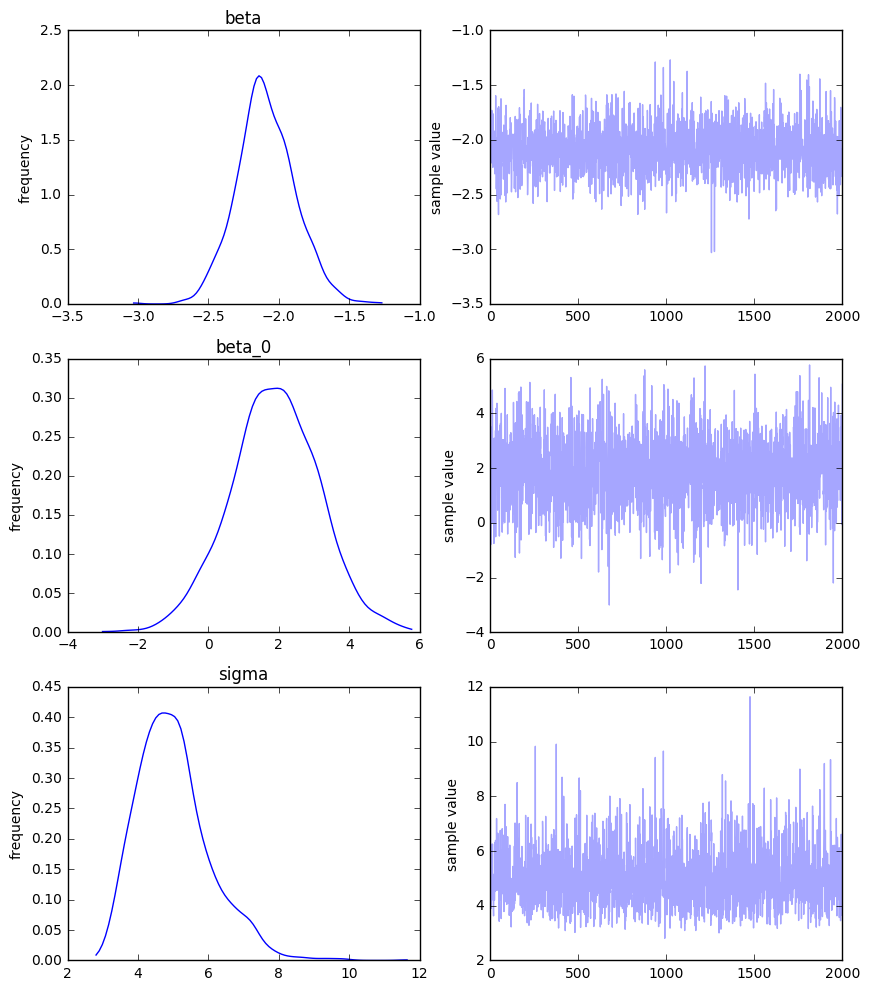

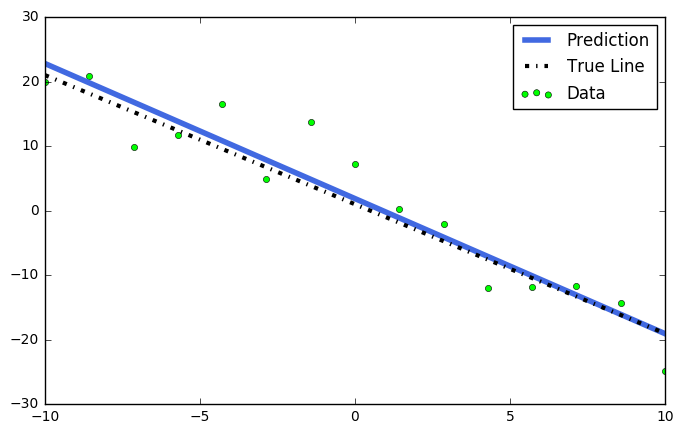

In [4]:
# stan plot shows up too small on this notebook. 
matplotlib.rcParams['figure.figsize'] = [10.0,12.0]

# Plot distribution of parameters
fit.plot()

# get estimates
beta_hat, beta0_hat, sigma_hat, l = fit.get_posterior_mean().mean(axis=1)

bayes_predict = lambda x: beta0_hat + beta_hat*x

p = plotData(X, Y, beta_0, beta, [x_low, x_hi], 
         estimates=[beta_hat,beta0_hat])

In [7]:
from sklearn.linear_model import LinearRegression

ols = LinearRegression()
ols.fit(X.reshape(-1, 1),Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

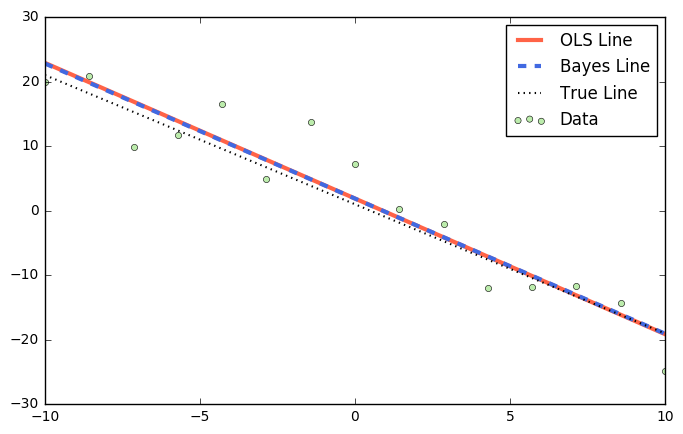

	 True Coefficients:	-2.000, 1.000
	  OLS Coefficients:	-2.100, 1.888	Error: 0.894
	Bayes Coefficients:	-2.091, 1.877	Error: 0.882


In [8]:
p = plt.figure("Data With Correct Line",
           figsize=[8,5])
plt.xlim(x_low, x_hi)

# Plot the data
plt.scatter(X, Y, lw=0.4, 
            edgecolors="black",
            color="lightsage", 
            label="Data")

# Plot the OLS line
plt.plot([x_low,x_hi], 
         [ols.predict(x_low),ols.predict(x_hi)],
         color="tomato",
         lw=3, ls="-",
         label="OLS Line")

# Plot the Bayesian line
plt.plot([x_low,x_hi],
         [bayes_predict(x_low),bayes_predict(x_hi)], 
         color="royalblue",
         lw=3, ls="--",
         label="Bayes Line")

# Plot the true line
plt.plot([x_low,x_hi],
         [x_low*beta+beta_0,x_hi*beta+beta_0], 
         color="k",
         lw=1.5, ls=":",
         label="True Line")

plt.legend(loc="best")

plt.show()
ols_error = np.sqrt((ols.coef_[0]-beta)**2 + (ols.intercept_-beta_0)**2)
bayes_error = np.sqrt((beta_hat-beta)**2 + (beta0_hat-beta_0)**2)
print("\t True Coefficients:\t{:0.3f}, {:0.3f}".format(beta, beta_0))
print("""\t  OLS Coefficients:\t{:0.3f}, {:0.3f}\tError: {:0.3f}""" \
      .format(ols.coef_[0], ols.intercept_, ols_error))
print("""\tBayes Coefficients:\t{:0.3f}, {:0.3f}\tError: {:0.3f}""" \
      .format(beta_hat, beta0_hat, bayes_error))